<a href="https://colab.research.google.com/github/Shopping-Yuan/ML_Project/blob/Shopping_vscode_branch/ML_Project/CNN_Classification/CNN_Classification_fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Download the dataset
# You may choose where to download the data.

# Google Drive
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Dropbox
# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# MEGA
# !sudo apt install megatools
# !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# Unzip the dataset.
# This may take some time.
!unzip -q food-11.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy
To: /content/food-11.zip
100% 963M/963M [00:06<00:00, 139MB/s]


In [4]:
#import pytorch
import torch

# torch.backends.cudnn: set CNN algorithmtorch.backends.cudnn
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# get the current available device ('cpu' or 'cuda')
def get_device():
#    return 'cpu'
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(torch.cuda.is_available())
#set random variable
import numpy as np
myseed = 1
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

True


In [5]:
from torchvision.transforms import v2
from torchvision.datasets import DatasetFolder
from torch.utils.data import ConcatDataset
from PIL import Image
def get_tfm(data_info):
    tfm = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(data_info["size"]),
    ])
    return tfm
def get_tfm_flip(data_info):
    tfm_flip = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
#      v2.RandomResizedCrop(size=data_info["size"],scale=(0.8, 1.0), antialias=True),
    v2.Resize(data_info["size"]),
    v2.RandomHorizontalFlip(p=1),
    ])
    return tfm_flip
def food_f(mode,data_info):
    dataset = DatasetFolder(data_info[mode]["path"], \
          loader=lambda x: Image.open(x), \
          extensions="jpg", transform=get_tfm(data_info))
    if mode in ["train_origin"]:
      dataset_flip = DatasetFolder(data_info[mode]["path"], \
          loader=lambda x: Image.open(x), \
          extensions="jpg", transform=get_tfm_flip(data_info))
      dataset = ConcatDataset([dataset,dataset_flip])
    print('Size of {} data: {}'.format(mode,len(list(dataset))))
    return dataset
#create a dict of functions and path w.r.t. different mode
data_info = {
    "train_origin":{"path":"./food-11/training/labeled"},
    "train":{"path":"./food-11/training/unlabeled"},
    "val":{"path":"./food-11/validation"},
    "test":{"path":"./food-11/testing"},
    "size" :(128,128)
}

In [6]:
h_paras = {
    # maximum number of epochs
    'n_epochs': 100,
    # mini-batch size for dataloader
    'batch_size': 128,
    # optimization algorithm (optimizer in torch.optim)
    'optimizer': 'Adam',
    # hyper-parameters for the optimizer (depends on which optimizer you are using)
    'optim_hparas': {
        # learning rate of Adam
        'lr': 0.0003,
        "weight_decay" : 1e-5
    },
    # your model will be saved here
    'save_path': './model.pth',
    'early_stop': 5,
    'threshold': 0.8,
}

In [7]:
from torch.utils.data import DataLoader

# Construct data loaders.
train_loader = DataLoader(food_f("train_origin",data_info), batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(food_f("val",data_info), batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(food_f("test",data_info), batch_size=h_paras["batch_size"], shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Size of train_origin data: 6160
Size of val data: 660
Size of test data: 3347


In [8]:
from torch import nn
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 32, 32]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.flat_layer = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(int(256 * data_info["size"][0]/16 * data_info["size"][1]/16), 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 11)
        )
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = self.flat_layer(x)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x
    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

In [10]:
class Label_Changable_dsf(DatasetFolder):
    def __init__(self,root,loader,extensions,transform):
            super().__init__(root, loader, extensions , transform,)
    def change_targets(self ,correct_target):
      for i , t in enumerate(correct_target):
        self.targets[i] = t
def food_semi_f(mode,data_info,DatasetFolder):
    dataset = DatasetFolder(data_info[mode]["path"], \
          loader=lambda x: Image.open(x), \
          extensions="jpg", transform=get_tfm(data_info))

    print('Size of data for semi-supervised-learning: {}'.format(len(list(dataset))))
    return dataset


In [11]:
from tqdm.auto import tqdm
from torch.utils.data import ConcatDataset , Subset
def get_pseudo_labels(model, training_loader ,h_paras):

    softmax = nn.Softmax(dim=-1)
    model.eval()
    # Construct a data loader.
    semi_datasetfolder = food_semi_f("train",data_info,Label_Changable_dsf)
    semi_dataset_loader = \
    DataLoader(semi_datasetfolder, \
               batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)


    correct_label = []
    correct_index = []

    for batch_num , batch in enumerate(tqdm(semi_dataset_loader)):
        img = batch[0]


        with torch.no_grad():
            img_d = img.to(device)
            prep = model(img_d)
        predicts = softmax(prep)
        max_prob , max_column_index = predicts.max(dim = -1)

        max_prob_list = max_prob.tolist()
        max_column_index_list = max_column_index.tolist()
        correct_label += [max_column_index_list[i]  \
                          for i in range(len(max_column_index_list)) if max_prob_list[i] > h_paras["threshold"]]
        correct_index += [(i + batch_num * h_paras["batch_size"]) \
                          for i in range(len(max_column_index_list)) if max_prob_list[i] > h_paras["threshold"]]

    if len(correct_index)>0:
      #
      semi_datasetfolder.change_targets(correct_label)
      add_train_set = Subset(semi_datasetfolder,correct_index)

      new_train_set = ConcatDataset([food_f("train_origin",data_info),add_train_set])
      training_loader = DataLoader(new_train_set, batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)


      #build a dic to print the number of label of each class added to add_train_set
      label_dict = {}
      label_set = set(correct_label)
      for i in label_set:
        label_dict[i] = correct_label.count(i)
      print("add total {} datas to training dataset, each label numbers as follow {}".format(len(correct_index),label_dict))

    return training_loader

In [ ]:
# label_dict = {}
# correct_index = [2,3,5,3,1]
# label_set = set(correct_index)
# for i in label_set:
#   print(correct_index.count(i))
#   label_dict[i] = correct_index.count(i)
#   print(label_dict.items())

In [ ]:
x = ["a","b","a"]
y = [1,2,3]
z = dict(zip(x,y))
print(z.items())

dict_items([('a', 3), ('b', 2)])


In [ ]:
# from torch.utils.data import Dataset
# class Semi_Dataset_preparation(Dataset):
#   def __init__(self,mode,datas,labels):
#       self.mode = mode
#       self.datas = torch.FloatTensor(datas)
#       self.labels = torch.LongTensor(labels)
#       self.dim = self.datas.shape[0]
#       print('Finished reading the {mode} set of Dataset ({len} samples found, each dim = {dim})'
#               .format(mode = self.mode, len =len(self.datas), dim=self.dim))

#   def __getitem__(self, index):
#       return self.datas[index], self.labels[index]
#   def __len__(self):
#       # Returns the size of the dataset
#       return len(self.datas)

In [ ]:
# from tqdm.auto import tqdm
# from torch.utils.data import ConcatDataset
# def get_pseudo_labels(model, training_loader , data_origin , label_origin ,h_paras , epoch):
#     threshold = h_paras["threshold"]
#     softmax = nn.Softmax(dim=-1)
#     model.eval()
#     # Construct a data loader.

#     train_unlabeled_loader = \
#     DataLoader(food_f("train",data_info), \
#                batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)

#     datas = np.array([])
#     labels = np.array([])
#     label_dict = {}
#     update = False
#     for batch in tqdm(train_unlabeled_loader):
#         img = batch[0]


#         with torch.no_grad():
#             img_d = img.to(device)
#             prep = model(img_d)
#         predicts = softmax(prep)
#         max_prob , max_column_index = predicts.max(dim = -1)
#         max_prob = max_prob.tolist()
#         max_column_index = max_column_index.tolist()
#         for row_index in range(len(predicts)):

#           if max_prob[row_index] > threshold:
#             if len(datas) ==0:
#               datas = torch.unsqueeze(img[row_index],0).numpy()
#               labels = np.array([max_column_index[row_index]])
#             else:
#               datas = np.concatenate((datas, torch.unsqueeze(img[row_index],0).numpy()), axis=0)
#               labels = np.concatenate((labels, np.array([max_column_index[row_index]])), axis=0)
#             if epoch%10 == 0:
#               label_dict[int(max_column_index[row_index])] = \
#               label_dict.get(int(max_column_index[row_index]),0)+1
#     add_num = len(datas)
#     if epoch%10 == 0:
#       print("add total {} datas to training dataset, each label numbers as follow {}".format(add_num,label_dict))
#     else :
#       print("add total {} datas to training dataset".format(add_num))
#     if (add_num)>0:
#       update = True
#       datas = np.concatenate((datas, data_origin), axis=0)
#       labels = np.concatenate((labels, label_origin), axis=0)

#       new_train_set = Semi_Dataset_preparation("unlabel_training",datas,labels)
# #      new_train_set = ConcatDataset([train_set_origin , add_set])
#       # for i in DataLoader(add_set,batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True):
#       #   print(i)
#       # for index,i in enumerate(DataLoader(new_train_set,batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)):
#       #   if index >25:
#       #     print(i)
#       training_loader = DataLoader(new_train_set, batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
#     model.train()
#     return training_loader , update

In [12]:
def train(train_loader,model_d,optimizer,device):
    # set model to training mode
    model_d.train()
    total_correct_number = 0
    train_loss_list = []
#    print(type(train_loader))
    # iterate through the dataloader
    for data , label in tqdm(train_loader):
      # move data to device (cpu/cuda)
      data_d , label_d = data.to(device), label.to(device)
      # forward pass (compute output tensor)
      pred = (model_d(data_d))
      # get the index of the class with the highest probability
      max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
      correct_number = (max_prob_indexs.cpu() == label_d.cpu()).sum().item()
#      print(correct_number)
      total_correct_number += correct_number
      # compute loss
      loss = model_d.cal_loss(pred , label_d)
      # compute gradient (backpropagation)
      loss.backward()
      # Clip the gradient norms for stable training.
      nn.utils.clip_grad_norm_(model_d.parameters(), max_norm=10)
      # update model with optimizer
      optimizer.step()
      # set optimizer gradient to zero
      optimizer.zero_grad()
      train_loss_list.append(loss.detach().cpu().item())
    acc = total_correct_number/len(train_loader.dataset)
#    print(acc , train_loss_list)
    return acc , train_loss_list

In [13]:
def val(val_loader,model_d,device):
    # set model to evalutation mode
    model_d.eval()
    total_correct_number = 0
    total_loss = 0
    # iterate through the dataloader
    for data , label in tqdm(val_loader):
    # move data to device (cpu/cuda)
      data_d, label_d = data.to(device), label.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(data_d)
        # get the index of the class with the highest probability
        max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
        total_correct_number += (max_prob_indexs.cpu() == label_d.cpu()).sum().item()
        # compute loss
        mse_loss = model_d.cal_loss(pred, label_d)
      # accumulate loss
      batch_size = len(data_d)
      total_loss += mse_loss.detach().cpu().item() * batch_size

    # compute averaged loss
    totol_size = len(val_loader.dataset)
    acc = total_correct_number/totol_size
    avg_loss =  total_loss/totol_size
    return acc, avg_loss

In [14]:
def train_val_process(training_loader, validation_loader, data_info, model, h_paras, device , do_semi = False):
    # Initialize a model, and put it on the device specified.
    model_d = model.to(device)
    model_d.device = device
    optimizer = torch.optim.Adam(model_d.parameters(), **h_paras["optim_hparas"])

    # The number of training epochs.
    n_epochs = h_paras["n_epochs"]

    # record training accuracy
    acc_record = {'train': [], "val": []}
    # record training loss
    loss_record = {'train': [], "val": []}

    # accuracy paras
    best_acc = 0
    # early-stoping paras
    early_stop_cnt = 0


    #for semi-supervised learning
    if do_semi == True:
      data_origin = np.array([])
      label_origin = np.array([])
      for data , label in tqdm(training_loader):
        if len(data_origin) ==0:
          data_origin = data.numpy()
          label_origin = np.array(label)
        else:
          data_origin = np.concatenate((data_origin, data.numpy()), axis=0)
          label_origin = np.concatenate((label_origin, np.array(label)), axis=0)


    for epoch in range(n_epochs):
        # ---------- Training ----------
        train_acc , train_loss_list = train(training_loader,model_d,optimizer,device)
        # save accuracy to acc_record['train']
        acc_record['train'].append(train_acc)
      # save loss to loss_record['train']
        loss_record['train'].append(train_loss_list)

        # ---------- Do semi-supervised learning ----------
        if ((do_semi == True) & (early_stop_cnt >= 1 )):

          training_loader = get_pseudo_labels(model_d, training_loader , h_paras)


        # ---------- Validation ----------
        val_acc , val_loss = val(validation_loader,model_d,device)
        # Print the information.
        acc_record["val"].append(val_acc)
        # save loss to loss_record["val"]
        loss_record["val"].append(val_loss)

        print(' model epoch = {:4d}, train_loss = {:.4f} , val_loss = {:.4f})'\
        .format(epoch+1 , train_loss_list[-1] , val_loss))
        print('train set accuracy = {:.3f}'.format(train_acc))

        # ---------- Early Stop ----------
        if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model.state_dict(), h_paras["save_path"])
          print('saving model with acc {:.3f}'.format(best_acc))
          early_stop_cnt = 0
        else:
          early_stop_cnt += 1
        # Check early stop criteria
        if early_stop_cnt > h_paras['early_stop']:
            # Stop training if your model stops improving
            # for "h_paras['early_stop']" epochs.
            break

    return acc_record , loss_record


In [15]:
# Construct model
model = Classifier()
model_acc_record, model_loss_record = train_val_process(train_loader, valid_loader, data_info, model, h_paras, device, do_semi = True)

  0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    1, train_loss = 1.5301 , val_loss = 2.3471)
train set accuracy = 0.251
saving model with acc 0.161


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    2, train_loss = 1.7275 , val_loss = 1.7726)
train set accuracy = 0.399
saving model with acc 0.368


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    3, train_loss = 2.1012 , val_loss = 1.6837)
train set accuracy = 0.452
saving model with acc 0.388


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    4, train_loss = 1.1655 , val_loss = 1.6217)
train set accuracy = 0.524
saving model with acc 0.433


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    5, train_loss = 1.1196 , val_loss = 1.9063)
train set accuracy = 0.572


  0%|          | 0/49 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


  0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 950 datas to training dataset, each label numbers as follow {0: 12, 1: 39, 2: 19, 3: 109, 4: 177, 5: 220, 6: 69, 7: 33, 8: 22, 9: 46, 10: 204}


  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    6, train_loss = 1.2875 , val_loss = 1.5966)
train set accuracy = 0.617
saving model with acc 0.467


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    7, train_loss = 1.2423 , val_loss = 1.6176)
train set accuracy = 0.574


  0%|          | 0/56 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


  0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 796 datas to training dataset, each label numbers as follow {0: 2, 1: 31, 2: 12, 3: 33, 4: 22, 5: 229, 6: 103, 7: 12, 8: 22, 9: 81, 10: 249}


  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    8, train_loss = 0.9532 , val_loss = 1.5117)
train set accuracy = 0.616
saving model with acc 0.482


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    9, train_loss = 1.2468 , val_loss = 1.6375)
train set accuracy = 0.670


  0%|          | 0/55 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


  0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1364 datas to training dataset, each label numbers as follow {0: 33, 1: 77, 2: 12, 3: 35, 4: 165, 5: 339, 6: 89, 7: 54, 8: 109, 9: 275, 10: 176}


  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   10, train_loss = 0.8937 , val_loss = 1.4822)
train set accuracy = 0.687
saving model with acc 0.529


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   11, train_loss = 0.8942 , val_loss = 1.6068)
train set accuracy = 0.666


  0%|          | 0/59 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


  0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1145 datas to training dataset, each label numbers as follow {0: 312, 1: 36, 2: 13, 3: 49, 4: 18, 5: 128, 6: 98, 7: 2, 8: 12, 9: 242, 10: 235}


  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   12, train_loss = 0.7218 , val_loss = 1.8278)
train set accuracy = 0.713


  0%|          | 0/58 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


  0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1622 datas to training dataset, each label numbers as follow {0: 217, 1: 101, 2: 5, 3: 123, 4: 35, 5: 563, 6: 62, 7: 19, 8: 89, 9: 279, 10: 129}


  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   13, train_loss = 0.7475 , val_loss = 1.7535)
train set accuracy = 0.760


  0%|          | 0/61 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


  0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1281 datas to training dataset, each label numbers as follow {0: 121, 1: 135, 2: 166, 3: 112, 4: 73, 5: 42, 6: 128, 7: 25, 8: 75, 9: 244, 10: 160}


  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   14, train_loss = 0.6989 , val_loss = 1.8207)
train set accuracy = 0.757


  0%|          | 0/59 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


  0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1426 datas to training dataset, each label numbers as follow {0: 813, 1: 85, 2: 70, 3: 86, 4: 5, 5: 72, 6: 176, 7: 7, 8: 10, 9: 12, 10: 90}


  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   15, train_loss = 0.6702 , val_loss = 2.1830)
train set accuracy = 0.796


  0%|          | 0/60 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


  0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1559 datas to training dataset, each label numbers as follow {0: 760, 1: 93, 2: 88, 3: 12, 4: 82, 5: 208, 6: 27, 7: 37, 8: 57, 9: 76, 10: 119}


  0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   16, train_loss = 0.9133 , val_loss = 1.9950)
train set accuracy = 0.810


In [16]:
def test(test_loader, model_d, device):
    # set model to evalutation mode
    model_d.eval()
    pred_index = []
    pred_loss = []
    # iterate through the dataloader
    for imgs, incorrect_labels in tqdm(test_loader):
      # move data to device (cpu/cuda)
      imgs_d = imgs.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(imgs_d)
        # get the index of the class with the highest probability
        max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
        # collect prediction
        pred_index += (max_prob_indexs.tolist())
        pred_loss += (pred.mean(dim = 1).tolist())
    # concatenate all predictions and convert to a numpy array
    np_pred_index , np_pred_loss = np.array(pred_index), np.array(pred_loss)
    pred_dict = { "pred_index" : np_pred_index , "pred_loss" : np_pred_loss }
    return pred_dict

In [17]:
def save_pred(preds, file_path):
    import pandas as pd
    print('Saving results to {}'.format(file_path))
    df = pd.DataFrame(preds,columns=["tested_positive"])
    df.to_csv(file_path)

In [18]:
preds = test(test_loader, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

  0%|          | 0/27 [00:00<?, ?it/s]

Saving results to pred.csv


In [19]:
#%conda install -c conda-forge matplotlib
import matplotlib.pyplot as plt
import statistics
def plot_learning_curve_loss(loss_record, title=''):

    #plot1 : train loss
    #plot2 : val loss
    train_data = []
    t = np.array(loss_record['train'])
    for i in t:
      train_data.append(statistics.mean(i))
    val_data = np.array(loss_record['val'])

    #setting index range
    total_steps = len(train_data)
    x_1 = range(total_steps)

    x_2 = x_1[::len(train_data) // len(val_data)]
    #figure size setting
    plt.figure(figsize=(6, 4))
    #plot train data
    plt.plot(x_1, train_data, c='tab:red', label='train')
    #plot val data
    plt.plot(x_2, val_data, c='tab:cyan', label='val')

    plt.ylim(0.0, 4.)
    #title & label setting
    plt.title('Learning curve of {}'.format(title))
    plt.xlabel('Training steps')
    plt.ylabel('Cross Entropy loss')
    #show legend
    plt.legend()
    #show plot
    plt.show()
def plot_learning_curve_acc(acc_record, title=''):

    #plot1 : train acc
    #plot2 : val acc
    train_data = np.array(acc_record['train'])
    val_data = np.array(acc_record['val'])

    #setting index range
    x_1 = range(len(train_data))
    x_2 = range(len(val_data))

    #figure size setting
    plt.figure(figsize=(6, 4))
    #plot train data
    plt.plot(x_1, train_data, c='tab:red', label='train')
    #plot val data
    plt.plot(x_2, val_data, c='tab:cyan', label='val')

    plt.ylim(0.0, 1.0)
    #title & label setting
    plt.title('Learning curve of {}'.format(title))
    plt.xlabel('Training steps')
    plt.ylabel('Cross Entropy loss')
    #show legend
    plt.legend()
    #show plot
    plt.show()

<ipython-input-19-25494a591fef>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.array(model_loss_record['train'])


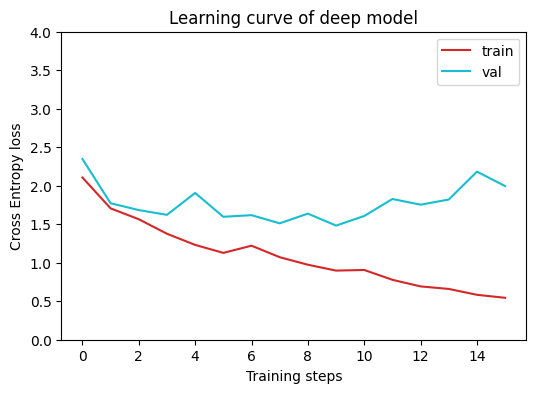

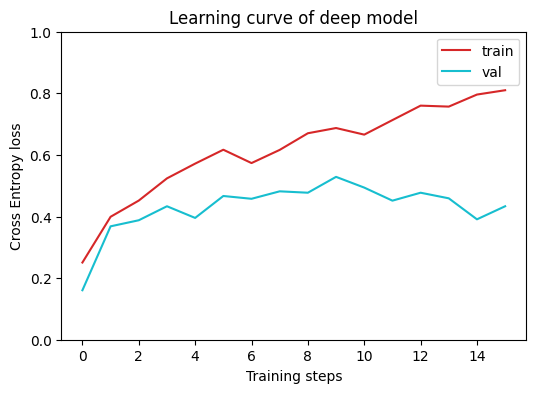

In [20]:
plot_learning_curve_loss(model_loss_record, title='deep model')
plot_learning_curve_acc(model_acc_record, title='deep model')

In [ ]:
# labels_map = {
#     0: "T-Shirt",
#     1: "Trouser",
#     2: "Pullover",
#     3: "Dress",
#     4: "Coat",
#     5: "Sandal",
#     6: "Shirt",
#     7: "Sneaker",
#     8: "Bag",
#     9: "Ankle Boot",
# }
# figure = plt.figure(figsize=(8, 8))
# cols, rows = 3, 3
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(training_data), size=(1,)).item()
#     img, label = training_data[sample_idx]
#     figure.add_subplot(rows, cols, i)
#     plt.title(labels_map[label])
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray")
# plt.show()
